In [302]:
from netgen.meshing import *
from ngsolve import *
from netgen.meshing import Mesh as NGMesh
from ngsolve.webgui import Draw
from netgen.geom2d import SplineGeometry, unit_square
import matplotlib.pyplot as plt
import numpy as np
import pickle
# Bem. stiw: unnötig wird in Zeile 2 schon geladen
#from ngsolve import CoefficientFunction
from ngsolve.meshes import MakeStructured2DMesh
import time

Hier wird eine lineare Funktion verwendet, um alle Werte von -1.5 bis 1.5 drin zu haben.

In [303]:
def fun(x):
    return -2+4*x

# x nicht überschreiben, das ist unsere CF für die Koordinaten...
xp = np.linspace(0,1,400)
fun_x = fun(xp)

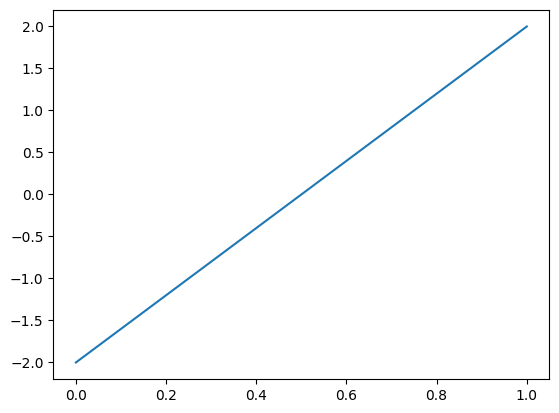

In [304]:
plt.plot(xp,fun_x)
plt.show()

In [305]:
#print(fun_x)

In [306]:
# generate a 1D mesh
ngmesh = NGMesh()
ngmesh.dim = 1

# Bem. stiw: wir brauchen etwas mehr Elemente als nur eines
nel = 200
l0 = 2

pnums = []
for i in range(0, nel+1):
    pnums.append (ngmesh.Add(MeshPoint (Pnt(i/nel*l0, 0, 0))))

for i in range(0,nel):
    ngmesh.Add (Element1D([pnums[i],pnums[i+1]], index=1))

ngmesh.Add (Element0D(pnums[0], index=1))
ngmesh.Add (Element0D(pnums[nel], index=2))

mesh = Mesh(ngmesh)

In [307]:
# Startwerte:
t0 = 0
dt0 = 2.5e-1
tend = 2
eps0 = 1e-2
d2t = 0.000  #Änderungsrate für dt

# Initialisierung der Parameter
t = Parameter (t0)
dt = Parameter (dt0)
eps = Parameter (eps0)

In [308]:
order = 2
# Bem. stiw: keine Dirichlet Randwerte
V = H1(mesh, order=order)#, dirichlet=[1,2])
u = V.TrialFunction()
v = V.TestFunction()
gfu = GridFunction(V)

a = BilinearForm (V, symmetric = False)
a += Variation((eps/2*grad(u)*grad(u) 
               +(u**2*(1-u*u)**2)
               + 0.5/dt*(u-gfu)**2)*dx)

# Interpolate the function onto the finite element space
# Bem. stiw: hier können wir die Koordinaten CF benutzen
u0 = GridFunction(V)
u0.Set(-2+4*x)
#oder
u0.Set(fun(x))

# Set the initial condition on the GridFunction
gfu.Set(-2+4*x)

In [309]:

gfu_array = np.array([GridFunction(V)])

for p in range (10):
    eps.Set(10**(-p))

    res = gfu.vec.CreateVector()
    du = gfu.vec.CreateVector()

    t.Set(0)
    gfu = GridFunction(V)
    
    # Newton Verfahren:
    start_time = time.time()
    for it in range(20):
        print("Newton iteration", it)
    
        # lösen des linearisierten Problems:
        # F(u_n)
        a.Apply (gfu.vec, res)
    
        # F'(u_n)
        a.AssembleLinearization(gfu.vec)
    
        #du.vec.data = a.mat.Inverse(V.FreeDofs(), inverse="umfpack") * res.vec
        #du.vec.data= a * res
        du.data = a.mat.Inverse(V.FreeDofs(), inverse="umfpack") * res
    
        # update gfu
        # u_n+1 = u_n - du
        gfu.vec.data -= du
    
        # eps für nächsten Zeitschritt updaten
        #eps.Set(eps.Get() * 1e-0)
        print("eps:", eps.Get())
    
        # Aktuelle Zeit updaten
        t.Set(t.Get()+dt.Get())
        print("Seconds passed: ", t.Get())
    
        # Abbruchkriterium: nach 2 Sekunden (wie in Aufgabenstellung beschrieben)
        t += dt.Get()
        print(t)
        if t > tend:
            break
    
        # dt für nächsten Schritt updaten
        dt.Set(dt.Get() + d2t)
        print("dt für nächste Iteration: ", dt.Get())
    
        # Abbruchkriterium: wenn es vor schon vor Ablauf der 2 Sekunden konvergiert
        stopcritval = sqrt(abs(InnerProduct(du,res)))
        print ("<A u",it,", A u",it,">_{-1}A0.S = ", stopcritval)
        print(gfu)
        if stopcritval < 1e-13:
            break
    end_time = time.time()
    time_to_compute = end_time - start_time
    
    gfu_array = np.concatenate((gfu_array, [gfu]), axis=0)



Newton iteration 0
eps: 1.0
Seconds passed:  0.25
ParameterCF, val = 0.5

dt für nächste Iteration:  0.25
<A u 0 , A u 0 >_{-1}A0.S =  6.4246270684341535
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 1
eps: 1.0
Seconds passed:  0.75
ParameterCF, val = 1

dt für nächste Iteration:  0.25
<A u 1 , A u 1 >_{-1}A0.S =  14.756867449699293
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 2
eps: 1.0
Seconds passed:  1.25
ParameterCF, val = 1.5

dt für nächste Iteration:  0.25
<A u 2 , A u 2 >_{-1}A0.S =  7.224576080425133
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 3
eps: 1.0
Seconds passed:  1.75
ParameterCF, val = 2

dt für nächste Iteration:  0.25
<A u 3 , A u 3 >_{-1}A0.S =  3.308705826545709
gridfunction 'gfu' on space 'H1HighOrderFESpace(h1ho)'
nested = 1
autoupdate = 0

Newton iteration 4
eps: 1.0
Seconds passed:  2.25
ParameterCF,

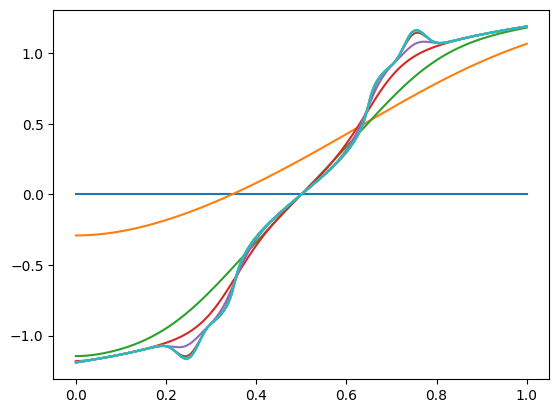

In [310]:
# Bem. stiw: Visualisierung

for p in range(10):
    plt.plot(xp,gfu_array[p](mesh(xp)).flatten())